# MODULES AND CONSTANTS 

### MODULES, CONSTANT AND IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




### CONSTANTS

In [2]:
INPUT_TRAINING_DATA = './NYC_Airbnb/Data/development.csv'
INPUT_TESTING_DATA = './NYC_Airbnb/Data/evaluation.csv'

# READ INPUT DATA

reads the input data, organized as such:
Each file has an initial header line, containing the names of attributes at your disposal:
- <b>id</b>: a unique identifier of the listing
- <b>name</b>
- <b>host_id</b>: a unique identifier of the host
- <b>host_name</b> 
- <b>neighborhood_group</b>: neighborhood location in the city
- <b>neighborhood</b>: name of the neighborhood
- <b>latitude</b>: coordinate expressed as floating point number
- <b>longitude</b>: coordinate expressed as floating point number
- <b>room_type</b>
- <b>price</b>: price per night expressed in dollars
- <b>minimum_nights</b>: minimum nights requested by the host
- <b>number_of_reviews</b>
- <b>last_review</b>: date of the last review expressed as YYYY-MM-DD
- <b>reviews_per_month</b>: average number of reviews per month
- <b>calculated_host_listings_count</b>: amount of listing of the host
- <b>availability_365</b>: number of days when the listing is available for booking

In [3]:
def readData(path:str)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=path, header=0, index_col=0)

# FILLS NA

Fills the found np.nan value:
<br>name                   13
<br>host_name              19
<br>last_review          8041
<br>reviews_per_month    8041

In [4]:
def replaceNa(df:pd.DataFrame)->pd.DataFrame:
    df['name'] = df['name'].replace({np.nan:'Anonimum'})
    df['host_name'] = df['host_name'].replace({np.nan:'Anonimum'})
    df['reviews_per_month'] = df['reviews_per_month'].replace({np.nan:0})
    return df.drop(labels=['last_review'], axis=1)

# Applies one hot encoding

In [5]:
def applyOneHot(df:pd.DataFrame, encoded:list[str]=None)->pd.DataFrame:
    for column in encoded or ['room_type', 'neighbourhood_group']:
        for label in set(df[column].values):
            df[label] = df[column].map(lambda x: 1 if x == label else 0)
        df = df.drop(labels=[column], axis=1)
    
    return df.drop(labels=['neighbourhood'], axis=1)

# FILTER DATA

Filters the data by removing the outliers:
- price higher than $\mu + 3 *\sigma$
- price lower than 2 $

In [9]:
def filterData(df:pd.DataFrame) -> pd.DataFrame:
    return df
[
        (df['price'] >= 20)
        & (df['price'] <= df['price'].mean() + 1.8* df['price'].std())
    ]

[id
 12783632     True
 3463385      True
 17572926     True
 33913644     True
 9405895     False
             ...  
 20678811     True
 29630190     True
 3811639      True
 2404708      True
 15310580     True
 Name: price, Length: 38332, dtype: bool]

# MAIN FUNCTION

This is the main function of the program given 

In [7]:
def main()->pd.DataFrame:
    return filterData(applyOneHot(replaceNa(readData(INPUT_TRAINING_DATA))))
    
df = main()

df = df.drop(['name', 'host_name'], axis=1)


# import seaborn as sns
# sns.pairplot(df)  # Pairwise scatter plots for all features

In [526]:
from sklearn.mixture import GaussianMixture

GaussianMixture(n_components=10).fit_predict(df.drop(['price'], axis=1))

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)}

In [504]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial Features of degree 3
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Instantiate HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_iter=100, random_state=42, **{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 20}, warm_start=True)

# Train the model
model.fit(X_train_poly, y_train)

# Make predictions
y_pred = model.predict(X_test_poly)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
mse

np.float64(0.018104674344765814)

In [516]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
col = df.columns
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=col)


for col in df.columns:
    df[col], _ = stats.boxcox(df[col] + 1)

In [517]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Split the data into features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with Polynomial Features and HistGradientBoostingRegressor
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial feature transformation
    ('model', HistGradientBoostingRegressor(max_iter=150, random_state=42, **{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 20}, warm_start=True))  # Model for regression
])

# Define parameter grid for both PolynomialFeatures and HistGradientBoostingRegressor
param_grid = {
    'poly__degree': [3],  # Trying different polynomial degrees
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Make predictions on the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

# Optionally, calculate R^2 to evaluate the goodness of fit
r2 = grid_search.best_estimator_.score(X_test, y_test)
print(f"Test R²: {r2}")


Best parameters: {'poly__degree': 3}
Test Mean Squared Error: 5.120623626824609e-06
Test R²: 0.5605978247573569


<Axes: >

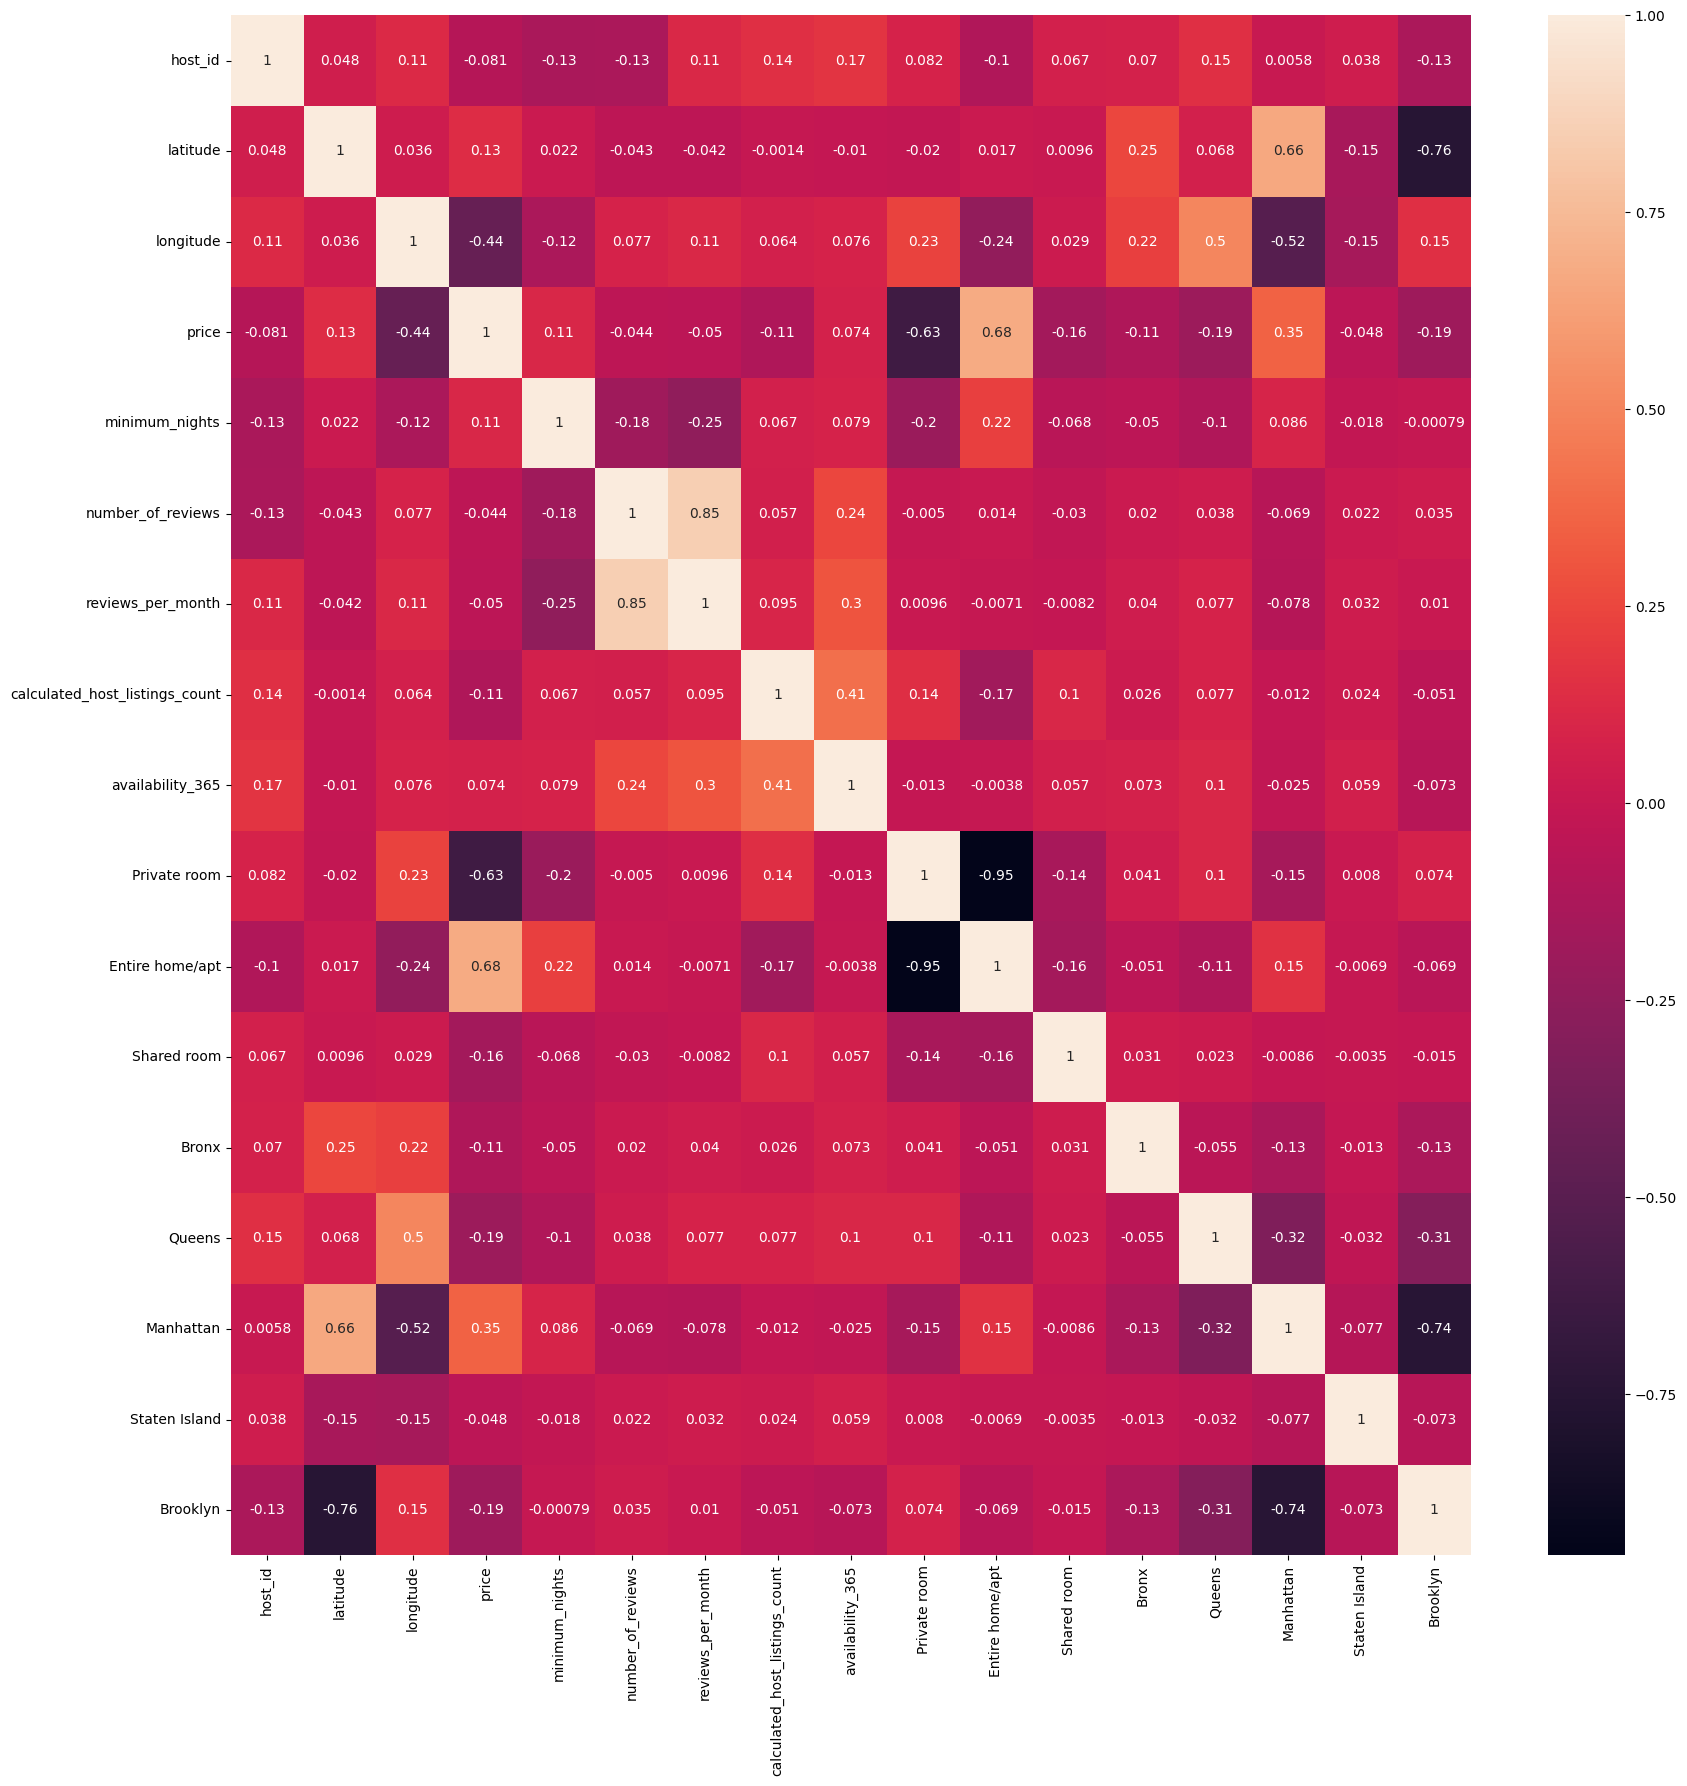

In [509]:
from seaborn import heatmap

plt.figure(figsize=(20,20))
heatmap(df.corr(method='spearman'), annot=True)

In [ ]:
# df
dfNoPrice = df[df.columns.difference(['price', 'host_name', 'name'])]
# dfNoPrice

In [ ]:
from seaborn import heatmap

plt.figure(figsize=(20,20))
heatmap(df.corr(method='kendall'), annot=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(df.drop('price', axis=1), df['price'])
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': df.drop('price', axis=1).columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
display(feature_importance_df)



                           Feature  Importance
8                  Entire home/apt    0.306908
2                        longitude    0.177180
1                         latitude    0.145543
0                          host_id    0.102799
7                 availability_365    0.080561
5                reviews_per_month    0.056303
3                   minimum_nights    0.048805
4                number_of_reviews    0.046195
6   calculated_host_listings_count    0.028602
10                    Private room    0.001622
9                      Shared room    0.001480
12                       Manhattan    0.001268
15                        Brooklyn    0.001224
13                          Queens    0.001019
14                           Bronx    0.000453
11                   Staten Island    0.000038


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['host_id'], axis=1), df['price'], test_size=0.2, random_state=42)


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20]
}

grid_search = GridSearchCV(HistGradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation MSE:", -grid_search.best_score_)


KeyboardInterrupt: 

In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

model = HistGradientBoostingRegressor()
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-np.mean(cv_scores)}")


Cross-validated MSE: 3.4024364076585676


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error



X_train, X_test, y_train, y_test = train_test_split(df[df.columns.difference(['price'])], df['price'], test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor(scoring='neg_mean_squared_error').fit(X_train, y_train)


result = permutation_importance(model, X_test, y_test, n_repeats=40, random_state=42, n_jobs=-1) 
feature_importances = result.importances_mean 
feature_names = model.feature_names_in_ 

for item in sorted(zip(feature_names, feature_importances), reverse=True, key=lambda x:x[1]):
    print(item)

ypred = model.predict(X_test)
r2_score(y_test, ypred), mean_squared_error(y_test, ypred)

['Entire home/apt', np.float64(0.5447460336860073)]
['longitude', np.float64(0.19459218591461297)]
['latitude', np.float64(0.11401427133824533)]
['availability_365', np.float64(0.09485350483907169)]
['minimum_nights', np.float64(0.06153011657722148)]
['number_of_reviews', np.float64(0.029281617309478102)]
['calculated_host_listings_count', np.float64(0.0204448972988438)]
['host_id', np.float64(0.015190779804898417)]
['reviews_per_month', np.float64(0.01224791384126125)]
['Private room', np.float64(0.005130935509655215)]
['Manhattan', np.float64(0.003857613785752881)]
['Brooklyn', np.float64(0.0029436486838553154)]
['Shared room', np.float64(0.0011119136652320478)]
['Bronx', np.float64(0.0001622372493660873)]
['Staten Island', np.float64(0.0)]
['Queens', np.float64(-5.086048497933704e-05)]


(0.5062183631576278, np.float64(4093.7256206779953))

In [ ]:
df['price'] = df['price'].map(lambda x: x+ 10-x%10)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(dfNoPrice, df['price'], test_size=0.2, random_state=42)

res = []
for param in ParameterGrid({
    'loss': ['squared_error', 'absolute_error', 'poisson', 'quantile'],
    'quantile':[0.2, 0.5, 0.7, None],
    'max_iter': [50, 100, 200],
    'max_leaf_nodes': [20, 31, 64, None],
    'max_depth':[5, 10, 20, None],
    'min_samples_leaf':[10, 20, 30],
    'l2_regularization': [0, 0.3, 1],
    'max_features':[0.5, 0.2, 0.98],
    'max_bins': [63, 127, 255, 512]
}):
    #try:
        model = HistGradientBoostingRegressor(categorical_features=dfNoPrice.dtypes.map(lambda x : str(x) == 'object'), scoring='neg_mean_squared_error', **param).fit(X_train, y_train)
        ypred = model.predict(X_test)
        res.append([param, r2_score(y_test, ypred), mean_squared_error(y_test, ypred)])
    #except Exception:
        #print(f'config {param} raised exception')


"""result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

feature_importances = result.importances_mean 
feature_names = model.feature_names_in_ 

for item in sorted([[name, importance] for name, importance in zip(feature_names, feature_importances)], key=lambda x: x[1], reverse=True):
    print(item)"""
    


In [ ]:
for item in sorted(res, key=lambda x:x[2]):
    print(item)

In [ ]:
df.isna().sum()[df.isna().sum() > 0] # Number of nan
# df['priceOverNight'] = df['price']/df['minimum_nights']
df

In [1]:
data = pd.DataFrame( [df.mean(numeric_only=True) + df.std(numeric_only=True)*i for i in range(-3,3+1)]).T
data.columns = pd.MultiIndex.from_arrays([[f'\u03BC {f'{i}*\u03C3' if i < 0 else (f'+{i}*\u03C3' if i > 0 else '') }'for i in range(-3,3+1)]])
data = data.T.drop(labels=['host_id'], axis=1)
data

NameError: name 'pd' is not defined

In [ ]:
df[['host_id', 'calculated_host_listings_count']][df['host_id'] == 219517861]

In [ ]:
# df[df['price']> 5000][['price','room_type', 'minimum_nights']].sort_values(ascending=False, by='price')

In [ ]:
# df[['price', 'neighbourhood_group']].groupby(['neighbourhood_group']).agg(lambda x : x.max() - x.mean())

In [ ]:
# df[['price', 'neighbourhood']].groupby(['neighbourhood']).agg(lambda x : x.mean()).sort_values(by='price', ascending=False)

In [ ]:
from seaborn import heatmap


heatmap(df.map(lambda x: {
    'Bronx':1,
    'Brooklyn':2,
    'Manhattan':3,
    'Queens':4,
    'Staten Island':5
}[x] if x in ['Bronx',
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island'] else x)[['price', 'Bronx',
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island']].corr(numeric_only=True), annot=True)


In [ ]:
heatmap(df[['price', 'Private room','Shared room','Entire home/apt']].corr(), annot=True)

In [ ]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(20, 20))  # Set the size of the figure to 20x20 inches
heatmap(df.corr(numeric_only=True, method='pearson'), annot=True)

# Show the plot
plt.show()


In [ ]:
# df = df[(df['price'] <= df['price'].mean() + 3*df['price'].std()) & (df['price']>10)]
# df = df.drop(['name', 'host_id','host_name','latitude', 'longitude', 'calculated_host_listings_count'], axis=1)
#df = df.drop(['Private room','Shared room','Entire home/apt'], axis=1)
df = df.drop(['name', 'host_name'], axis=1)
df

In [ ]:
df.sort_values(by='price')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

temp = df.drop(['host_id', 'latitude', 'longitude'], axis=1)

df2 = pd.DataFrame(MinMaxScaler().fit_transform(temp), columns=temp.columns)
df2
# no scaler, lower r2

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it contains the features and 'price' column
X_scaled = StandardScaler().fit_transform(df[df.columns.difference(['price'])])

x = PCA().fit(pd.DataFrame(X_scaled, columns=df.columns.difference(['price'])))

cumulative_explained_variance = np.cumsum(x.explained_variance_ratio_)

# Find the number of components needed to explain 99% variance
components_needed = np.argmax(cumulative_explained_variance >= 0.99) + 1

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')

# Add feature names as labels
for i, txt in enumerate(x.feature_names_in_):
    plt.annotate(txt, (i + 1, cumulative_explained_variance[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add a red vertical line at the 99% explained variance point
plt.axvline(x=components_needed, color='red', linestyle='--')
plt.text(components_needed, 0.5, '99% explained variance', color='red', ha='center')

# Show the plot
plt.grid(True)
plt.show()

temp = x.transform(df[df.columns.difference(['price'])])
temp

In [ ]:
temp = df.drop(['host_id', 'latitude', 'longitude', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365', 'minimum_nights'], axis=1)
temp

In [18]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, Ridge, LinearRegression, LogisticRegression, BayesianRidge, ARDRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor

# temp = pd.DataFrame(temp, columns=list(list(x.feature_names_in_)))

# x, X, y, Y = train_test_split(temp[temp.columns.difference(['price'])], temp['price'], test_size=0.2)
x, X, y, Y = train_test_split(df[df.columns.difference(['price'])], df['price'], test_size=0.2)

"""regressors = [RandomForestRegressor(), KNeighborsRegressor(), ExtraTreeRegressor(), DecisionTreeRegressor(),
              ElasticNet(), ElasticNetCV(), Lasso(), Ridge(), LinearRegression(), LogisticRegression(solver='liblinear', fit_intercept=True),
              SVR(), GradientBoostingRegressor(), HistGradientBoostingRegressor(), AdaBoostRegressor(), RadiusNeighborsRegressor(),
              BayesianRidge(), ARDRegression(), SGDRegressor(), TransformedTargetRegressor(), MLPRegressor()
              ]"""
regressors = [RandomForestRegressor(n_jobs=-1), HistGradientBoostingRegressor()]

res = []


for regressor in regressors:
    try:
        mod = regressor.fit(x, y).predict(X)
        res.append([str(regressor),r2_score(Y, mod), mean_squared_error(Y, mod)])
    except Exception:
        print(f'regressor {str(regressor)} produced an exception')    
    
for item in sorted(res, key=lambda x:x[1], reverse=True):
    print(item)

['HistGradientBoostingRegressor()', 0.512951140026455, np.float64(3990.0940883871244)]
['RandomForestRegressor(n_jobs=-1)', 0.5001663217372918, np.float64(4094.8323026998823)]


In [425]:
ypred = pd.read_csv(filepath_or_buffer=INPUT_TESTING_DATA, header=0, index_col=0).drop(labels=['name', 'host_name', 'last_review'], axis=1).replace({np.nan:0})

In [427]:
ypred = applyOneHot(ypred)[df.columns.difference(['price'])]

In [428]:
df[df.columns.difference(['price'])]
dfNoPrice

,Bronx,Brooklyn,Entire home/apt,Manhattan,Private room,Queens,Shared room,Staten Island,availability_365,calculated_host_listings_count,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month
id,,,,,,,,,,,,,,,,
12783632,0,0,0,0,1,1,0,0,351,3,57230304,40.74037,-73.88610,1,2,0.92
3463385,0,0,0,1,1,0,0,0,263,2,10698270,40.76717,-73.95532,1,202,3.31
17572926,0,0,1,1,0,0,0,0,0,1,36578169,40.77984,-73.94725,2,0,0.00
33913644,0,1,1,0,0,0,0,0,89,1,50981314,40.70205,-73.91338,2,4,1.64
9405895,0,1,1,0,0,0,0,0,103,1,48775347,40.68914,-73.97853,3,16,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678811,0,1,0,0,1,0,0,0,306,3,147972663,40.64850,-73.93855,3,58,2.57
29630190,0,1,0,0,1,0,0,0,0,2,223032162,40.68602,-73.99023,2,15,1.80
3811639,0,1,1,0,0,0,0,0,308,1,10603767,40.70784,-73.92224,3,203,3.42


In [429]:
ser = pd.Series(HistGradientBoostingRegressor(categorical_features=dfNoPrice.dtypes.map(lambda x : str(x) == 'object'), warm_start=True, scoring='neg_mean_squared_error',
                **{'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 20})
                .fit(dfNoPrice, df['price']).predict(ypred[dfNoPrice.columns]), 
                index=pd.MultiIndex.from_arrays([ypred.index], names=['Id']), name='Predicted').map(lambda x:round(x))
ser



Id      
2539        108
5121         57
5203         98
5238        219
6848        174
           ... 
36478343    119
36481315    266
36482809    135
36484665     87
36485057     82
Name: Predicted, Length: 9779, dtype: int64

In [430]:
ser.to_csv('out.csv')

Estimated Shape: 2.6479319341261993
Estimated Scale: 50.299147757961514


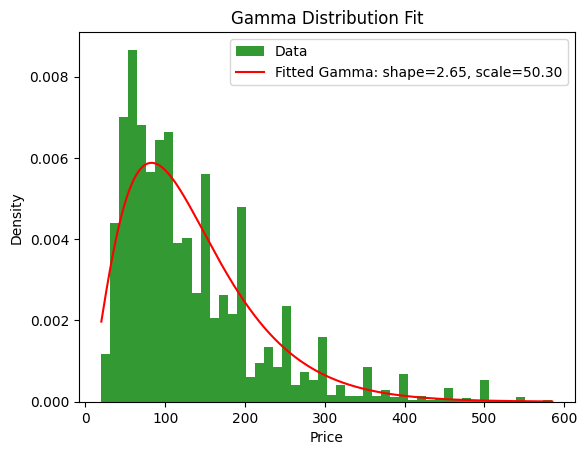

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming you have a DataFrame 'df' with a 'price' column
# Example (replace this with your actual DataFrame):
# df = pd.DataFrame({'price': np.random.gamma(2.0, 1.0, 1000)})

# Extract the 'price' column from the DataFrame
data = df[df['price']>0]['price'].values

# Fit the Gamma distribution to the data
params = stats.gamma.fit(data, floc=0)  # Set location parameter to 0

# Extract the estimated parameters
shape_est, loc_est, scale_est = params
print(f"Estimated Shape: {shape_est}")
print(f"Estimated Scale: {scale_est}")

# Plot the histogram of the data and the fitted Gamma distribution
plt.hist(data, bins=50, density=True, alpha=0.8, color='g', label='Data')

# Create the x-values for the fitted Gamma distribution
x = np.linspace(min(data), max(data), 10000)

# Plot the fitted Gamma distribution
pdf_fitted = stats.gamma.pdf(x, shape_est, loc_est, scale_est)
plt.plot(x, pdf_fitted, 'r-', label=f'Fitted Gamma: shape={shape_est:.2f}, scale={scale_est:.2f}')

# Label the plot
plt.title('Gamma Distribution Fit')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


## GMM Approach

In [537]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame and it contains a target column 'price'
df = df.drop(columns=['host_id', 'calculated_host_listings_count', 'availability_365', 'reviews_per_month'])

col = df.columns


# Step 1: Scale the features using MinMaxScaler
scaler_X = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_X.fit_transform(df.drop(columns='price')), columns=col[:-1])

# Target variable
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42)

# Step 2: Fit the Gaussian Mixture Model to the training data
gmm = GaussianMixture(n_components=5, random_state=42)  # You can change n_components as needed
gmm.fit(X_train)

# Step 3: Calculate feature importance using the covariance matrix of the GMM
# We'll focus on the diagonal elements (variances of individual features) from each component
covariances = gmm.covariances_  # Covariance matrix for each component
weights = gmm.weights_  # Mixing weights for each component

# Calculate feature importance by summing variances across all components, weighted by their mixing weights
importance = np.zeros(X_train.shape[1])

for i in range(gmm.n_components):
    # The diagonal of the covariance matrix corresponds to the variance of each feature in the i-th component
    importance += weights[i] * np.diag(covariances[i])

# Step 4: Sort features by importance (higher importance first)
feature_importance = pd.Series(importance, index=X_train.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

# Step 5: Select the top n features (for example, top 3 features)
top_features = feature_importance_sorted.head(3).index
print(top_features)
# Use only the selected top features for further modeling
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Step 6: Train a HistGradientBoostingRegressor with the selected features
model = HistGradientBoostingRegressor(max_iter=100, random_state=42, 
                                      learning_rate=0.05, max_depth=3, 
                                      min_samples_leaf=20, warm_start=True)

model.fit(X_train_selected, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test_selected)

# Step 8: Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")





Index(['Private room', 'number_of_reviews', 'Entire home/apt'], dtype='object')
Mean Squared Error: 5886.997905194404
